In [14]:
import torch
from torch import nn
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from tqdm.auto import tqdm, trange
from ipywidgets import IntProgress
import time
from torch import nn
from torch.nn import functional as F
from torchmetrics.functional.regression import mean_absolute_percentage_error

import sys
sys.path.insert(0, '../ml')
from NGO import *
from VarMiON import *
from DataModule import *
from logger import *
from trainer import train
from customlosses import *

import matplotlib.pyplot as plt

In [15]:
class GaussianRBF(nn.Module):
    def __init__(self, params, input_dim, output_dim):
        super().__init__()
        self.params = params
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hparams = params['hparams']
        self.reset_nontrainableparameters()
        
    def reset_parameters(self):
        self.mus = nn.Parameter(torch.Tensor(self.output_dim, self.input_dim))
        self.log_sigmas = nn.Parameter(torch.Tensor(self.output_dim))
        nn.init.uniform_(self.mus, 0, 1)
        nn.init.constant_(self.log_sigmas, np.log((1/self.hparams['h'])**(1/self.params['simparams']['d'])))
                                     
    def reset_nontrainableparameters(self):
        mu_0, mu_1 = np.mgrid[0:1:int(self.hparams['h']**(1/2))*1j, 0:1:int(self.hparams['h']**(1/2))*1j]        
        mus = np.vstack([mu_0.ravel(), mu_1.ravel()]).T
        self.mus = torch.tensor(mus)
        print(self.mus.shape)
        self.log_sigmas = torch.ones(self.output_dim)*np.log((1/self.hparams['h']**(1/self.params['simparams']['d'])))               
                                     
    def forward(self, x):
        d_scaled = (x[:,None,:] - self.mus[None,:,:])/torch.exp(self.log_sigmas[None,:,None])
        y = torch.exp(-torch.sum(d_scaled**2, axis=-1)/0.5)
        if self.hparams.get('norm_basis',False)==True:
            y = y/torch.sum(y, axis=-1)[:,None]
        return y
    
    def grad(self, x):
        prefactor = -1/((torch.exp(self.log_sigmas[None,:,None]))**2)*(x[:,None,:] - self.mus[None,:,:])
        return prefactor*self.forward(x)[:,:,None]

In [16]:
hparams = {'accelerator': 'gpu',
           'devices': [1],
           'dtype': torch.float32,
           'precision': 16,
           'loss_terms': [F.mse_loss],
           'loss_coeffs': [1],
           'metric': L2_scaled,
           'optimizer': torch.optim.Adam, 
           'learning_rate': 1e-4,
           'batch_size': 100,
           'max_epochs': 5000,
           'early_stopping_patience': 1000000,
           'VarMiON': True,
           'Q': 100,
           'Q_L': 268,
           'h': 9, 
           'Petrov-Galerkin': False,
           'bias_NLBranch': False,
           'bias_LBranch': False,
           'NLB_outputactivation': nn.Tanhshrink(),
           'Cholesky': False,
           'scale_invariance': False,
           'norm_basis': False,
           'bound_mus': False,
           '1/theta': False,
           'symgroupavg': False,
           'NOMAD': False}

params = {}
params['hparams'] = hparams
simparams = {}
simparams['d'] = 2
params['simparams'] = simparams

In [17]:
rbf = GaussianRBF(params, input_dim=2, output_dim = hparams['h'])

torch.Size([9, 2])


(-0.05, 1.05, -0.05, 1.05)

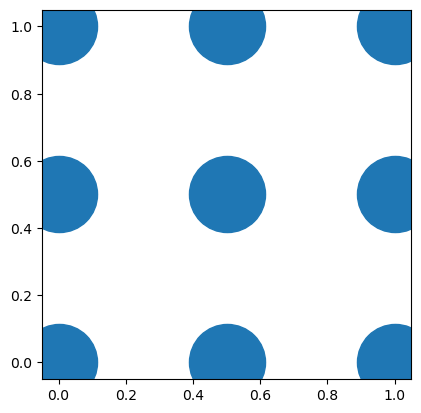

In [18]:
mus = rbf.mus.detach().numpy()
log_sigmas = rbf.log_sigmas.detach().numpy()
sigmas = np.exp(log_sigmas)
plt.scatter(mus[:,0], mus[:,1], s=9000*sigmas[0])
sigmas
plt.axis('square')

In [19]:
x_0_Q, x_1_Q = np.mgrid[0:1:hparams['Q']*1j, 0:1:hparams['Q']*1j]
x_Q = np.vstack([x_0_Q.ravel(), x_1_Q.ravel()]).T
x_Q = torch.tensor(x_Q, dtype=hparams['dtype'])

print(rbf.forward(x_Q).shape)
print(x_Q.shape)

torch.Size([10000, 9])
torch.Size([10000, 2])


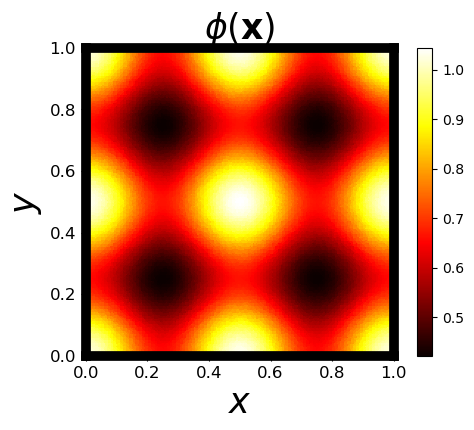

In [30]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 12
size_axeslabels = 25
box_lw = 7

fig = ax.tripcolor(x_Q[:,0], x_Q[:,1], torch.sum(rbf.forward(x_Q), axis=-1), cmap='hot')
ax.set_title(r"$\phi(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)

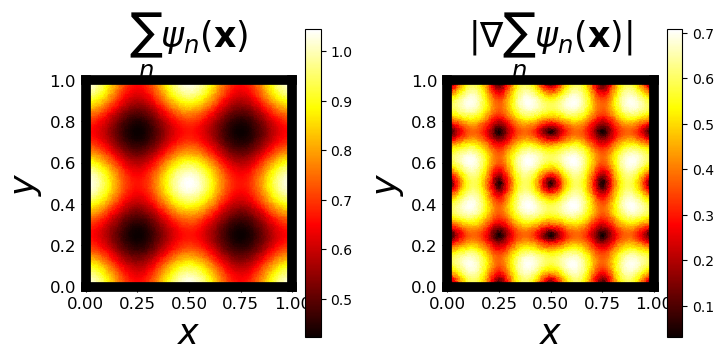

In [37]:
grad = rbf.grad(x_Q)
sumgrad = torch.sum(grad, dim=1)
abssumgrad = torch.sqrt(torch.sum(sumgrad**2, axis=-1))

fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 12
size_axeslabels = 25
box_lw = 7

ax=axs[0]
fig = ax.tripcolor(x_Q[:,0], x_Q[:,1], torch.sum(rbf.forward(x_Q), axis=-1), cmap='hot')
ax.set_title(r"$\sum_n \psi_n(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x_Q[:,0], x_Q[:,1], abssumgrad, cmap='hot')
ax.set_title(r"$|\nabla\sum_n\psi_n(\mathbf{x})|$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)